In [1]:
from WNQuery import *


QUERY = WNQuery('./plwordnet-3.2-visdisc.xml', log=open('pywnxml.log', 'w'))

In [2]:
# Znajdź wszystkie znaczenia rzeczownika szkoda oraz wymień ich synonimy (jeśli posiadają).
for synset in QUERY.lookUpLiteral('szkoda', 'n'):
    print(synset.toString())

PLWN-00003675-n  {strata:1, utrata:1, szkoda:2, uszczerbek:1}  ()
PLWN-00006533-n  {szkoda:1}  (brak danych)


PLWN-00410901-n  {wypadek komunikacyjny:1}  ()
PLWN-00003982-n  {wypadek:1}  ()
PLWN-00027419-n  {zdarzenie oceniane negatywnie:1}  (brak danych)
PLWN-00006526-n  {wydarzenie:1, wypadek:3, zdarzenie:2, historia:3}  ()


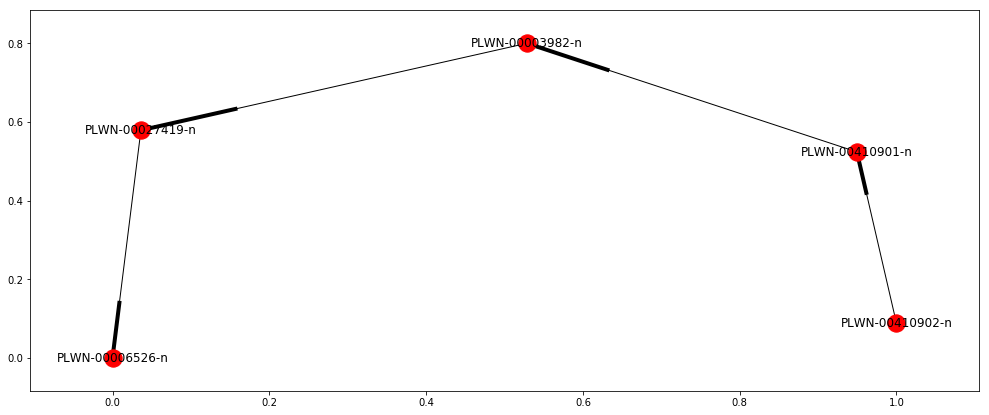

In [5]:
# Znajdź domknięcie przechodnie relacji hiperonimi dla pierwszego znaczenia wyrażenia 
# wypadek drogowy i przedstaw je w postaci grafu skierowanego.
from collections import deque

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


POS = 'n'
RELATION = 'hypernym'


synset = QUERY.lookUpSense('wypadek drogowy', 1, POS)
edges = []
vertices = deque([synset.wnid])
while vertices:
    vertex = vertices.popleft()
    for neighbour_vertex in QUERY.lookUpRelation(vertex, POS, RELATION):
        vertices.append(neighbour_vertex)
        edges.append((vertex, neighbour_vertex))
        print(QUERY.getSynset(neighbour_vertex, POS).toString())


%matplotlib inline
G = nx.DiGraph()
G.add_edges_from(edges)
plt.figure(figsize=(17,7)) 
nx.draw_networkx(G)

In [6]:
# Znajdź bezpośrednie hiponimy rzeczownika wypadek1.
POS = 'n'
RELATION = 'hyponym'

synset = QUERY.lookUpSense('wypadek', 1, POS)
for hyponym_synset in QUERY.lookUpRelation(synset.wnid, POS, RELATION):
    print(QUERY.getSynset(hyponym_synset, POS).toString())

PLWN-00001284-n  {zderzenie:2, kraksa:1}  ()
PLWN-00006486-n  {kolizja:2}  ()
PLWN-00016131-n  {karambol:1}  ()
PLWN-00034688-n  {zawał:2}  ()
PLWN-00034689-n  {tąpnięcie:1}  ()
PLWN-00241026-n  {kapotaż:1}  ()
PLWN-00258639-n  {wykolejenie:2}  ()
PLWN-00389170-n  {zakrztuszenie:1, zachłyśnięcie:1, aspiracja:3}  ()
PLWN-00410901-n  {wypadek komunikacyjny:1}  ()
PLWN-00411618-n  {katastrofa budowlana:1}  ()
PLWN-00436137-n  {wypadek jądrowy:1}  ()


In [7]:
# Znajdź hiponimy drugiego rzędu dla rzeczownika wypadek1.
POS = 'n'
RELATION = 'hyponym'

synset = QUERY.lookUpSense('wypadek', 1, POS)
for hyponym_order1 in QUERY.lookUpRelation(synset.wnid, POS, RELATION):
    for hyponym_order2 in QUERY.lookUpRelation(hyponym_order1, POS, RELATION):
        print(QUERY.getSynset(hyponym_order2, POS).toString())

PLWN-00235346-n  {czołówka:9, zderzenie czołowe:1}  ()
PLWN-00471555-n  {stłuczka:1}  ()
PLWN-00441365-n  {kolizja drogowa:1}  ()
PLWN-00037295-n  {obwał:1}  ()
PLWN-00410902-n  {wypadek drogowy:1}  ()


In [ ]:
# Przedstaw w postaci grafu skierowanego (z etykietami dla krawędzi) relacje semantyczne pomiędzy następującymi grupami leksemów:
# szkoda2, strata1, uszczerbek1, szkoda majątkowa1, uszczerbek na zdrowiu1, krzywda1, niesprawiedliwość1, nieszczęście2.
G1 = [
    ('szkoda', 2),
    ('strata', 1),
    ('uszczerbek', 1),
    ('szkoda majątkowa', 1),
    ('uszczerbek na zdrowiu', 1),
    ('krzywda', 1),
    ('niesprawiedliwość', 1),
    ('nieszczęście', 2)
]

G2 = [
    ('wypadek', 1),
    ('wypadek komunikacyjny', 1),
    ('kolizja', 2),
    ('zderzenie', 2),
    ('kolizja drogowa', 1),
    ('bezkolizyjny', 2),
    ('katastrofa budowlana', 1),
    ('wypadek drogowy', 1)
]




In [8]:
# Znajdź wartość miary pokrewieństwa semantycznego Leacocka-Chodorowa pomiędzy następującymi parami leksemów 
POS = 'n'
RELATION = 'hypernym'


MAX_DEPTH = max(QUERY.getMaxDepth(wnid, POS, RELATION) for wnid in QUERY.m_ndat)
print(MAX_DEPTH)

35


In [10]:
import math


LEXEMS = [
    (('szkoda', 2), ('wypadek', 1)),
    (('kolizja', 2), ('szkoda majątkowa', 1)),
    (('nieszczęście', 2), ('katastrofa budowlana', 1))
]


def path_len(wnid1, wnid2):
    ci_r1 = None
    ci_r2 = None
    path_length = 2 * MAX_DEPTH
    for key1, val1 in QUERY.getReach(wnid1, POS, RELATION, False):
        for key2, val2 in QUERY.getReach(wnid2, POS, RELATION, False):
            if key1 == key2:
                if val1 + val2 < path_length:
                    ci_r1 = (key1, val1)
                    ci_r2 = (key2, val2)
                    path_length = val1 + val2

    return path_length - 1 # because the common node was counted twice


for lexem1, lexem2 in LEXEMS:
    synset1 = QUERY.lookUpSense(lexem1[0], lexem1[1], POS)
    synset2 = QUERY.lookUpSense(lexem2[0], lexem2[1], POS)
    path_length = path_len(synset1.wnid, synset2.wnid)
    lch_similarity = -1.0 * math.log10(path_length / (2.0 * MAX_DEPTH))
    print(f'LCH similarity between {lexem1} and {lexem2} is {lch_similarity:0.4f} with path len {path_length}')

LCH similarity between ('szkoda', 2) and ('wypadek', 1) is 1.2430 with path len 4
LCH similarity between ('kolizja', 2) and ('szkoda majątkowa', 1) is 1.0669 with path len 6
LCH similarity between ('nieszczęście', 2) and ('katastrofa budowlana', 1) is 0.0062 with path len 69
